# Imports

In [14]:
import numpy as np
from matplotlib import pyplot as plt
from mnOPSuite.PRISM.python import scandelay_FTIR as sd
from importlib import reload

from scipy.optimize import leastsq,minimize
from scipy.stats import binned_statistic
from scipy.interpolate import interp1d
from common import numerical_recipes as numrec
from common.baseclasses import AWA
from common import numerics as num
import time
import warnings
warnings.filterwarnings('ignore')

dX=None
flattening_order=10
Nx=20
interp_kwargs=dict(bounds_error=False,
                   fill_value=0,
                   kind='cubic')
delay_calibration_factor=-2.5

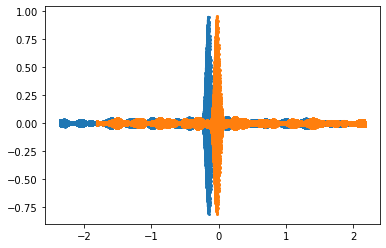

In [27]:
intfgs_arr=np.loadtxt('interferograms.txt')
Nx=intfgs_arr.shape[1]
plt.figure()

i=0
y=intfgs_arr[2*i,:Nx//2]
x=intfgs_arr[2*i+1,:Nx//2]
#x=numrec.smooth(x,window_len=50,axis=0)
plt.plot(x,y,marker='o',ms=2)


i=0
y=intfgs_arr[2*i,Nx//2:]
x=intfgs_arr[2*i+1,Nx//2:]
#x=numrec.smooth(x,window_len=50,axis=0)
plt.plot(x,y,marker='o',ms=2)

#plt.xlim(-6.9,-6.7)
#plt.ylim(-5,5)

In [28]:
reload(sd)
result = sd.align_interferograms_test(intfgs_arr, delay_calibration_factor=-3.09,
                         shift0=None,optimize_shift=True,shift_range=15,
                         flattening_order=5,noise=0,
                         fit_xs=True, fit_xs_order=6,smooth_xs = 0)

[-2.26252776e+00 -7.57887149e-02 -5.88915437e-04  3.00325848e+01
  4.42187330e-03  2.06665807e+02  7.46511852e-04  3.83322594e+02
  2.87433987e-04  2.40769163e+02 -1.34939972e-04  4.68495283e+02]
Re-using pre-existing x-axis for interferograms...
x0: 0.2692197901317845
Fwd/bwd dx separation: -0.3758096072296801
Initially optimal shift: -213
Finally optimal shift: -208


In [23]:
pdb on

Automatic pdb calling has been turned ON


# Rolling alignment

In [101]:
reload(sd)

<module 'mnOPSuite.PRISM.python.scandelay_FTIR' from 'C:\\Users\\mnopl\\Desktop\\Software\\mnOPSuite\\PRISM\\python\\scandelay_FTIR.py'>

In [102]:
result0=sd.align_interferograms_test(intfgs_arr, delay_calibration_factor=1,
                                 flattening_order=20, noise=0,
                                shift0=0,optimize_shift=False,shift_range=7)
result=sd.align_interferograms_test(intfgs_arr, delay_calibration_factor=1,
                                 flattening_order=20, noise=0,
                                shift0=0,optimize_shift=True,shift_range=7)

(-5.0, 5.0)

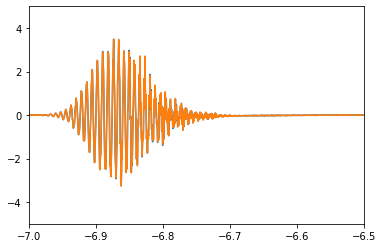

In [103]:
plt.plot(result0[1],result0[0])
plt.plot(result[1],result[0])
plt.xlim(-7,-6.5)
plt.ylim(-5,5)

In [99]:
pdb on

Automatic pdb calling has been turned ON
